https://www.kaggle.com/code/mahdyr/augmented-dataset-generator

the created dataset can get accessed in https://www.kaggle.com/datasets/mahdyr/dcase-2025-task1-melspecs-aug

In [1]:
import numpy as np
import os
import csv
import torch
import torchaudio
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

params = {
    'dataset_dir': "audio",
    'train_csv_file': "/kaggle/input/impulseresponse-audio-dataset/dcaseDataset_augIR/inf.csv",
    'train_files_base_path': "/kaggle/input/impulseresponse-audio-dataset/dcaseDataset_augIR/AugmentedSamples/",
    'original_fs': 44100,
    'target_fs': 32000,
    'fft_size': 4096,
    'hop_length': 502,
    'nb_mels': 256,
}

def plot_single_mel_spectrogram(mel_spec, label, dev):
    # Plot the mel-spectrogram
    plt.figure(figsize=(10, 3))
    plt.imshow(mel_spec, origin='lower', aspect='auto', cmap='viridis')
    plt.title(f"Class: {label}, Device: {dev}")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(label="Log2 Magnitude")
    plt.tight_layout()
    plt.show()

rm: cannot remove '/kaggle/working/dataset': No such file or directory


Precomputing and saving mel-spectrograms to /kaggle/working/dataset/train.npz ...
Batch 0/264 finished
Batch 1/264 finished
Batch 2/264 finished
Batch 3/264 finished
Batch 4/264 finished
Batch 5/264 finished
Batch 6/264 finished
Batch 7/264 finished
Batch 8/264 finished
Batch 9/264 finished
Batch 10/264 finished
Batch 11/264 finished
Batch 12/264 finished
Batch 13/264 finished
Batch 14/264 finished
Batch 15/264 finished
Batch 16/264 finished
Batch 17/264 finished
Batch 18/264 finished
Batch 19/264 finished
Batch 20/264 finished
Batch 21/264 finished
Batch 22/264 finished
Batch 23/264 finished
Batch 24/264 finished
Batch 25/264 finished
Batch 26/264 finished
Batch 27/264 finished
Batch 28/264 finished
Batch 29/264 finished
Batch 30/264 finished
Batch 31/264 finished
Batch 32/264 finished
Batch 33/264 finished
Batch 34/264 finished
Batch 35/264 finished
Batch 36/264 finished
Batch 37/264 finished
Batch 38/264 finished
Batch 39/264 finished
Batch 40/264 finished
Batch 41/264 finished
Batc

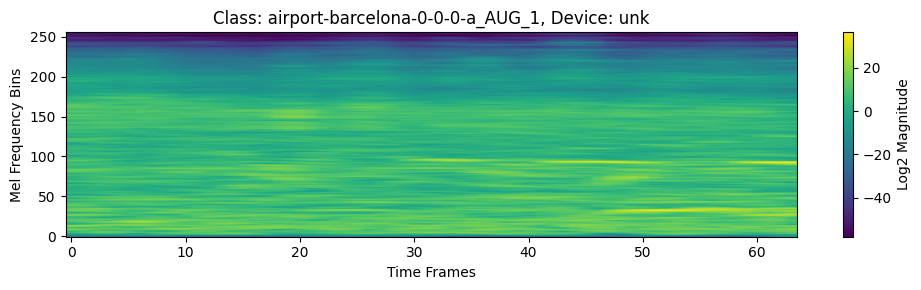

In [2]:
# Data Generator class
class DataGenerator(Dataset):
    def __init__(self, params, mode='train'):  # mode = 'train' or 'test'
        self.params = params
        self.dataset_dir = params['dataset_dir']
        self.mode = mode
        if self.mode == 'train':
            self.csv_file = params['train_csv_file']
            self.base_path = params['train_files_base_path']
        else:
            self.csv_file = params['test_csv_file']
            self.base_path = params['test_files_base_path']

        self.filenames, self.labels, self.devices = self.read_csv_file()

        # Transforms
        self.resampler = torchaudio.transforms.Resample(orig_freq=params['original_fs'], new_freq=params['target_fs'])
        self.mel_spec_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.params['target_fs'],
            n_fft=self.params['fft_size'],
            hop_length=self.params['hop_length'],
            n_mels=self.params['nb_mels'],
            power=2.0
        )
        self.db_transform = torchaudio.transforms.AmplitudeToDB()

    def __getitem__(self, item):
        audio_file = self.filenames[item]
        label = self.labels[item]
        device = self.devices[item]
        # Load audio
        waveform, sr = torchaudio.load(audio_file)
        # print(f"original sample rate :{sr}, original length: {waveform.shape}")
        waveform = torch.mean(waveform, dim=0, keepdim=True)  # Mono
        waveform = self.resampler(waveform)
        # print(f"after resampling length: {waveform.shape}")
        # Compute log mel-spectrogram
        mel_spec = self.mel_spec_transform(waveform)
        log_mel_spec = torchaudio.functional.amplitude_to_DB(mel_spec, multiplier=10.0, amin=1e-10, db_multiplier=0.0)
        return log_mel_spec, device, label
        

    def __len__(self):
        return len(self.filenames)

    def read_csv_file(self):
        audio_filenames = []
        labels = []
        cities = []
        devices = []
        with open(self.csv_file, 'r') as file:
            reader = csv.reader(file, delimiter='\t')
            next(reader)
            for row in reader:
                audio_filename, label, _ = row[0].split(',')
                devices.append('unk')
                audio_filenames.append(self.base_path + audio_filename)
                labels.append(label)
        return audio_filenames, labels, devices

train_dataset = DataGenerator(params=params, mode='train')

# Creating all the dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=512, num_workers=0, shuffle=False
)

# # For test on CPU
# train_loader = torch.utils.data.DataLoader(
#     Subset(train_dataset, range(16)), batch_size=4, num_workers=0, shuffle=False
# )

def precompute_and_save_mel_spectrograms(data_loader, dataset, meta_name):
    print(f"Precomputing and saving mel-spectrograms to {meta_name}.npz ...")
    # Inside your function...
    all_data = {
        'name':[],
        'mel':[],
        'device':[],
        'label': []
    }
    outdir = '/'.join(meta_name.split('/')[0:-1])
    os.makedirs(outdir, exist_ok=True)
   
    for batch_idx, (mel_spec, device, label) in enumerate(data_loader):
        for i in range(mel_spec.shape[0]):
            audio_file = dataset.filenames[batch_idx * data_loader.batch_size + i]
            filename = os.path.basename(audio_file).replace('.wav', '')
            all_data['name'].append(filename)
            all_data['mel'].append(mel_spec[i].squeeze().cpu().numpy())
            all_data['device'].append('unk')
            all_data['label'].append(label[i])    
            
        print(f"Batch {batch_idx}/{len(data_loader)} finished")
        
    np.savez_compressed(
        meta_name,
        name=all_data['name'],
        mel=all_data['mel'],
        device=all_data['device'],
        label=all_data['label']
    )
    print("✅ Mel-spectrograms and metadata saved successfully.\n\n")

precompute_and_save_mel_spectrograms(train_loader, train_dataset, "/kaggle/working/dataset/train")

mel_file_path = "/kaggle/working/dataset/train.npz" # Path to the .npz file
data = np.load(mel_file_path) # Load the .npz file
mel_specs = data['mel']  # Loaded as a numpy array
print("Mel Spectrogram shape:", mel_specs.shape, end="\n\n") # Print shapes/types to verify

plot_single_mel_spectrogram(mel_specs[0], label=data['name'][0], dev=data['device'][0])